In [2]:
import os
import scipy.io
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.image import imread

### Oscillator PINN

In [5]:
def exact_solution(d, w0, t):
    '''
    Defines the analytical solution to the under-damped harmonic 
    oscillator problem above.
    '''
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

class FCN(nn. Module): 
    '''
    Defines a standard fully-connected network in PyTorch
    '''
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn.Sequential(*[nn. Sequential(*[ nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [ ]:
torch.manual_seed(123)

# Define the output folder for the images
output_folder = os.path.join(os.getcwd(), "images")
os.makedirs(output_folder, exist_ok=True)

# Define list for loss values to be plotted
losses = []

# Define the PINN model
pinn = FCN(1, 1, 32, 3)

# Define boundary points for the boundary loss
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)

# Define training points over the entire domain for the physics loss
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

# Define the parameters in the PDE
d, w0 = 2, 20
mu, k = 2*d, w0**2

# Arrays for validating
t_test = torch.linspace(0, 1, 100).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)

optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

# Define the number of epochs
num_epochs = 15000

# Train the PINN
for i in range(num_epochs):
    optimizer.zero_grad()

    # Loss coefficients
    lambda1, lambda2 = 1e-1, 1e-4

    # Compute the boundary loss
    u_pred = pinn(t_boundary)
    loss1 = (torch.squeeze(u_pred) - 1)**2
    # boundary_loss = torch.mean((u_pred - 0)**2)

    dudt = torch.autograd.grad(u_pred, t_boundary, torch.ones_like(u_pred), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2

    # Compute the physics loss
    u_pred = pinn(t_physics)

    dudt = torch.autograd.grad(u_pred, t_physics, torch.ones_like(u_pred), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u_pred)**2)

    # Compute the total loss
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        losses.append(loss.item())
        print(f"Epoch {i}: Loss {loss}")
        u = pinn(t_test).detach()
        plt.figure(figsize=(4, 4))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, c='g', alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, c='r', alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact Solution", c='pink')
        plt.plot(t_test[:,0], u[:,0], label="PINN Solution", c='b')
        plt.title(f"Training Step {i}")
        plt.legend()
        
        image_path = os.path.join(output_folder, 
                                  "epoch_{:0{width}d}.png".format(i, width=len(str(num_epochs))))
        plt.savefig(image_path)
        plt.close()

In [19]:
import imageio

os.listdir(output_folder)
images = [imageio.imread(os.path.join(output_folder, f"{image}")) for image in os.listdir(output_folder) if image.endswith(".png")]
imageio.mimsave(os.path.join(os.getcwd(), 'animation.gif'), images, fps=30, duration=0.1, loop=0)

C:\Users\dsash\AppData\Local\Temp\ipykernel_16816\2480283814.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(os.path.join(output_folder, f"{image}")) for image in os.listdir(output_folder) if image.endswith(".png")]


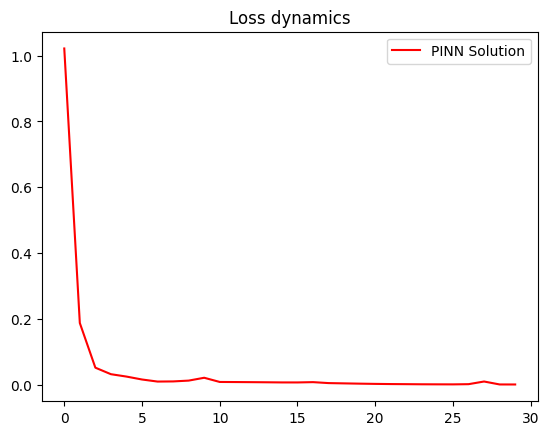

In [20]:
plt.plot(list(range(len(losses))), losses, label="PINN Solution", c='r')
plt.title(f"Loss dynamics")
plt.legend()